# Weather forecasting using graph neural networks and LSTM

**Author:** Simone Rossetti<br>
**Last modified:** 13/06/2023<br>
**Description:** This notebook demonstrates how to do weather timeseries forecasting over graphs in [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) dataset. 

## Introduction

This example shows how to forecast weather condition using graph neural networks and LSTM.
Specifically, we are interested in predicting the future values of `{'100m_u_component_of_wind', '100m_v_component_of_wind',
                '10m_u_component_of_wind', '10m_v_component_of_wind',
                '2m_temperature', '2m_dewpoint_temperature', 'surface_pressure', 'total_precipitation',
                'medium_cloud_cover'}` given
a history for a collection of weather stations.

One popular method to solve this problem is to consider each weather station as a separate
timeseries and predict the future values of each timeseries using the past values of the same timeseries.

This method, however, ignores the dependency on
the neighboring segments. To be able to take into account the complex interactions between
neighboring stations, we can define the network
as a graph and consider the sthocastic variables as a signal on this graph. In this example,
we implement a neural network architecture which can process timeseries data over a graph.
We first show how to process the data and create a
[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for
forecasting over graphs. Then, we implement a model which uses graph convolution and
LSTM layers to perform forecasting over a graph.

The project is partially based on [this example](https://keras.io/examples/timeseries/timeseries_traffic_forecasting/).

The data processing and the model architecture are inspired by this paper:

Yu, Bing, Haoteng Yin, and Zhanxing Zhu. "Spatio-temporal graph convolutional networks:
a deep learning framework for traffic forecasting." Proceedings of the 27th International
Joint Conference on Artificial Intelligence, 2018.
([github](https://github.com/VeritasYin/STGCN_IJCAI-18))

In [1]:
# set-up GPU visibility
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set which GPU to use
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true'
# os.environ["TF_GPU_ALLOCATOR"]='cuda_malloc_async'
import tensorflow as tf
print(f'CUDA AVAILABLE: {tf.test.is_gpu_available(cuda_only=True)}')
print(f'TENSORFLOW VERSION: {tf.__version__}')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_devices = tf.config.experimental.list_logical_devices('GPU')
        print(f'PHYSICAL GPUs: {len(gpus)}')
        print(f'LOGICAL GPUs: {len(logical_devices)}')
    except RuntimeError as e:
        print(f'ERROR: {e}') # Memory growth must be set before GPUs have been initialized
else: 
    print('WARNING: no GPU found!')

2023-06-13 17:55:45.458865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
CUDA AVAILABLE: True
TENSORFLOW VERSION: 2.12.0
PHYSICAL GPUs: 1
LOGICAL GPUs: 1


2023-06-13 17:55:48.299147: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-13 17:55:48.299185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 6666 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-06-13 17:55:48.301764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6666 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


## Setup

In [2]:
import pandas as pd
import numpy as np
import os
import math
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import xarray as xr
from tqdm import tqdm

## Data preparation

### Data description

We use a real-world weather forecasting dataset `Copernicus ERA5`, namely the `reanalysis-era5-single-levels`. Full description is available  
[here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).

The data has the foillowing specifics:
- Dataset length: 179019
- Dataset start: 2003-01-01
- Dataset end: 2023-06-04
- Dataset time resolution: 1 hours
- Dataset longitude: 6.0 - 19.0, resolution: 1.0 deg
- Dataset longitude: 48.0 - 36.0, resolution: 1.0 deg
- Variables name:
	- u100: [m s**-1] 100 metre U wind component
	- v100: [m s**-1] 100 metre V wind component
	- u10: [m s**-1] 10 metre U wind component
	- v10: [m s**-1] 10 metre V wind component
	- t2m: [K] 2 metre temperature
	- d2m: [K] 2 metre dewpoint temperature
	- sp: [Pa] Surface pressure
	- tp: [m] Total precipitation
	- z: [m**2 s**-2] Geopotential
	- mcc: [(0 - 1)] Medium cloud cover

Get your API key from [here](https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key) or you can find it in your [user page](https://cds.climate.copernicus.eu/user/), place the API key in `download_era5_reanalysis.py` and run the script to download the datasets (typically it takes few hours for copernicus to prepare your query).

### Loading data

In [3]:
import glob
ROOTDIR = '10vars'
FILEEXT = 'nc'
ds_list = sorted(glob.glob(f'{ROOTDIR}/*.{FILEEXT}'))

In [4]:
datas = []

for ds_name in ds_list:
    ds = xr.open_dataset(ds_name)
    if 'expver' in ds:
        ds = ds.reduce(np.nansum,'expver')
    datas.append(ds)
ds = xr.concat(datas, 'time')

print(f'Dataset length: {len(ds.time)}')
print(f'Dataset start: {ds.time.values[0].astype("datetime64[D]")}')
print(f'Dataset end: {ds.time.values[-1].astype("datetime64[D]")}')
print(f'Dataset time resolution: {np.max(np.diff(ds.time.values.astype("datetime64[h]")))}')
print(f'Dataset longitude: {ds.longitude.values[0]} - {ds.longitude.values[-1]}, resolution: {np.max(np.abs(np.diff(ds.longitude.values)))} deg')
print(f'Dataset longitude: {ds.latitude.values[0]} - {ds.latitude.values[-1]}, resolution: {np.max(np.abs(np.diff(ds.latitude.values)))} deg')

variables = list(ds.keys())
print(f'Variables name:')
for var in variables:
    print(f'\t{var}: [{ds[var].units}] {ds[var].long_name}')

Dataset length: 179019
Dataset start: 2003-01-01
Dataset end: 2023-06-04
Dataset time resolution: 1 hours
Dataset longitude: 6.0 - 19.0, resolution: 1.0 deg
Dataset longitude: 48.0 - 36.0, resolution: 1.0 deg
Variables name:
	u100: [m s**-1] 100 metre U wind component
	v100: [m s**-1] 100 metre V wind component
	u10: [m s**-1] 10 metre U wind component
	v10: [m s**-1] 10 metre V wind component
	t2m: [K] 2 metre temperature
	d2m: [K] 2 metre dewpoint temperature
	sp: [Pa] Surface pressure
	tp: [m] Total precipitation
	z: [m**2 s**-2] Geopotential
	mcc: [(0 - 1)] Medium cloud cover


In [5]:
geopotential = ds.z.isel(time=0) # store geopotential
ds = ds.drop('z') # remove from variables
variables = list(ds.keys())

### Visualize some samples with `cartopy`

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


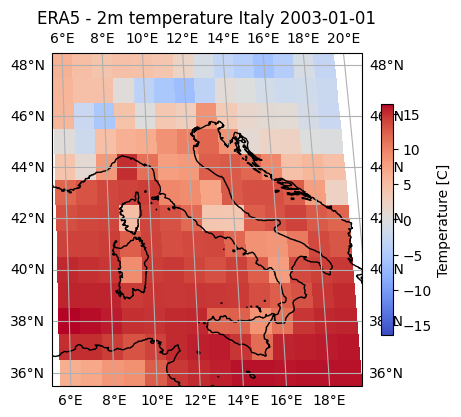

In [6]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)
temp = ds.t2m[0] - 273.15
plot = temp.plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6, "label": "Temperature [C]"})
plt.title(f"ERA5 - 2m temperature Italy {temp.time.to_numpy().astype('datetime64[D]')}")
plt.show()

Here we visualize the temperature over decades:

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


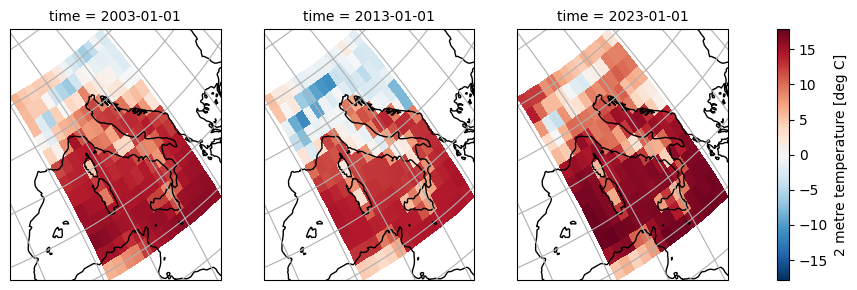

In [23]:
times = [np.datetime64('2003-01-01'), np.datetime64('2013-01-01'), np.datetime64('2023-01-01')]
p = ds.t2m.isel(time=ds.time.isin(times)) - 273.15
p.attrs = ds.t2m.attrs
p.attrs['units'] = 'deg C'
p = p.plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-40, 35)},
) 
for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()
plt.draw()

We can also visualize the height of the surface by converting the geopotential:

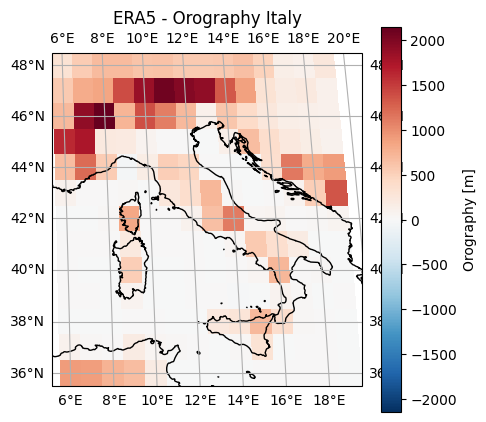

In [25]:
p = geopotential / 9.80665 # [m**2/s]
p.attrs = geopotential.attrs
p.attrs['units']='m'
p.attrs['long_name']='Orography'

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)
p = p.plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(-40, 35)},
) 
plt.title(f"ERA5 - Orography Italy")
plt.draw()


We can observe the wind directions histogram for different altitudes:

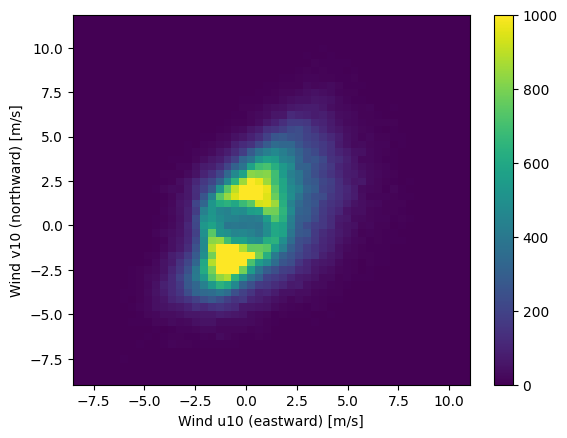

Text(0, 0.5, 'Wind v100 (northward) [m/s]')

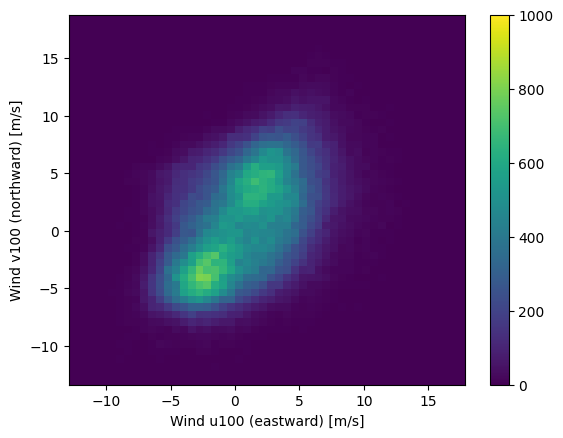

In [27]:
plt.hist2d(ds.u10[:,0,0], ds.v10[:,0,0], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.xlabel('Wind u10 (eastward) [m/s]')
plt.ylabel('Wind v10 (northward) [m/s]')
plt.show()

plt.hist2d(ds.u100[:,0,0], ds.v100[:,0,0], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.xlabel('Wind u100 (eastward) [m/s]')
plt.ylabel('Wind v100 (northward) [m/s]')


# Distances 

![earth](https://www.thoughtco.com/thmb/UrEYthFxKdG0NaAo_a987Qt0lrk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/Latitude-and-Longitude-58b9d1f35f9b58af5ca889f1.jpg)

There are 90 degrees of latitude between the Equator and each of the Poles. If we were to circumnavigate Earth, starting at the North Pole, then heading directly south to the South Pole, then heading north again to the North Pole, we would cover 360 degrees of latitude. This is not surprising, since the circumnavigation path would be a circle.

Furthermore, the total distance covered on our voyage would be 25,000 miles, the circumference of the spherical earth. Therefore we can easily compute that 1 degree of latitude is equal to 25,000 / 360 or 69.4 miles (111.1 km). Table 1 shows the approximate length in miles, kilometers, feet and meters for further subdivisions of a degree.

![lat](https://www.sco.wisc.edu/wp-content/uploads/2022/01/length-table1-1024x276.jpg)

Longitude is a little trickier. There are 180 degrees of longitude in each direction, east and west, from the Prime Meridian (which is at 0 degrees longitude). These measurements meet at the meridian located at 180 East and West. The number of degrees of longitude covered if we circumnavigated Earth around the Equator would therefore be 360.

However, unlike latitude, lines of longitude converge at the poles, which means that the length of a degree of longitude is not constant. At the Equator, it will be 69.4 miles, just like latitude. But as you move north or south, the distance shrinks by a factor equal to the cosine of the latitude. Table 2 shows this relationship.

![long](https://www.sco.wisc.edu/wp-content/uploads/2022/01/length-table2-1024x302.jpg)

The approximate conversions are:

Latitude: 1 deg = 110.574 Km
Longitude: 1 deg = 111.320*cos(latitude) Km

Max distance:  1832.719


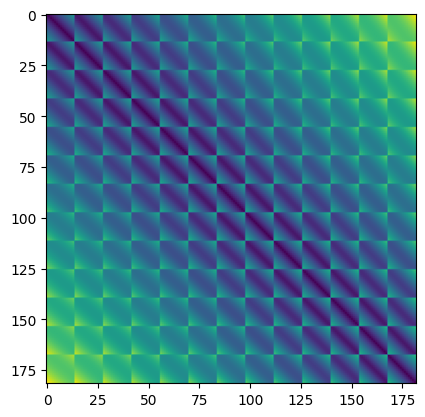

In [29]:
# plot distance matrix of the nodes
g = 9.80665 # [m**2/s]
altitude_km = (geopotential / g).values / 1_000 # [km]
latitude_km = 110.574 * (np.tile(ds.latitude.values[...,None],(1,ds.longitude.values.shape[0]))) # [km]
logitude_km = 111.320 * (np.tile(ds.longitude.values[None],(ds.latitude.values.shape[0],1))) * np.cos(np.deg2rad(ds.latitude.values))[...,None] # [km]
coords_km = np.reshape(np.stack([latitude_km, logitude_km, altitude_km],axis=-1),(-1,3)) # [km]
distances = np.sum((coords_km[:,None] - coords_km[None])**2,axis=-1)**0.5 # [km]
print('Max distance: ', distances.max())
distances /= np.max(distances)
plt.imshow(distances)

In [30]:
print(f"distances shape={distances.shape}")

distances shape=(182, 182)


### Data visualization

Here are the timeseries for the station 0:

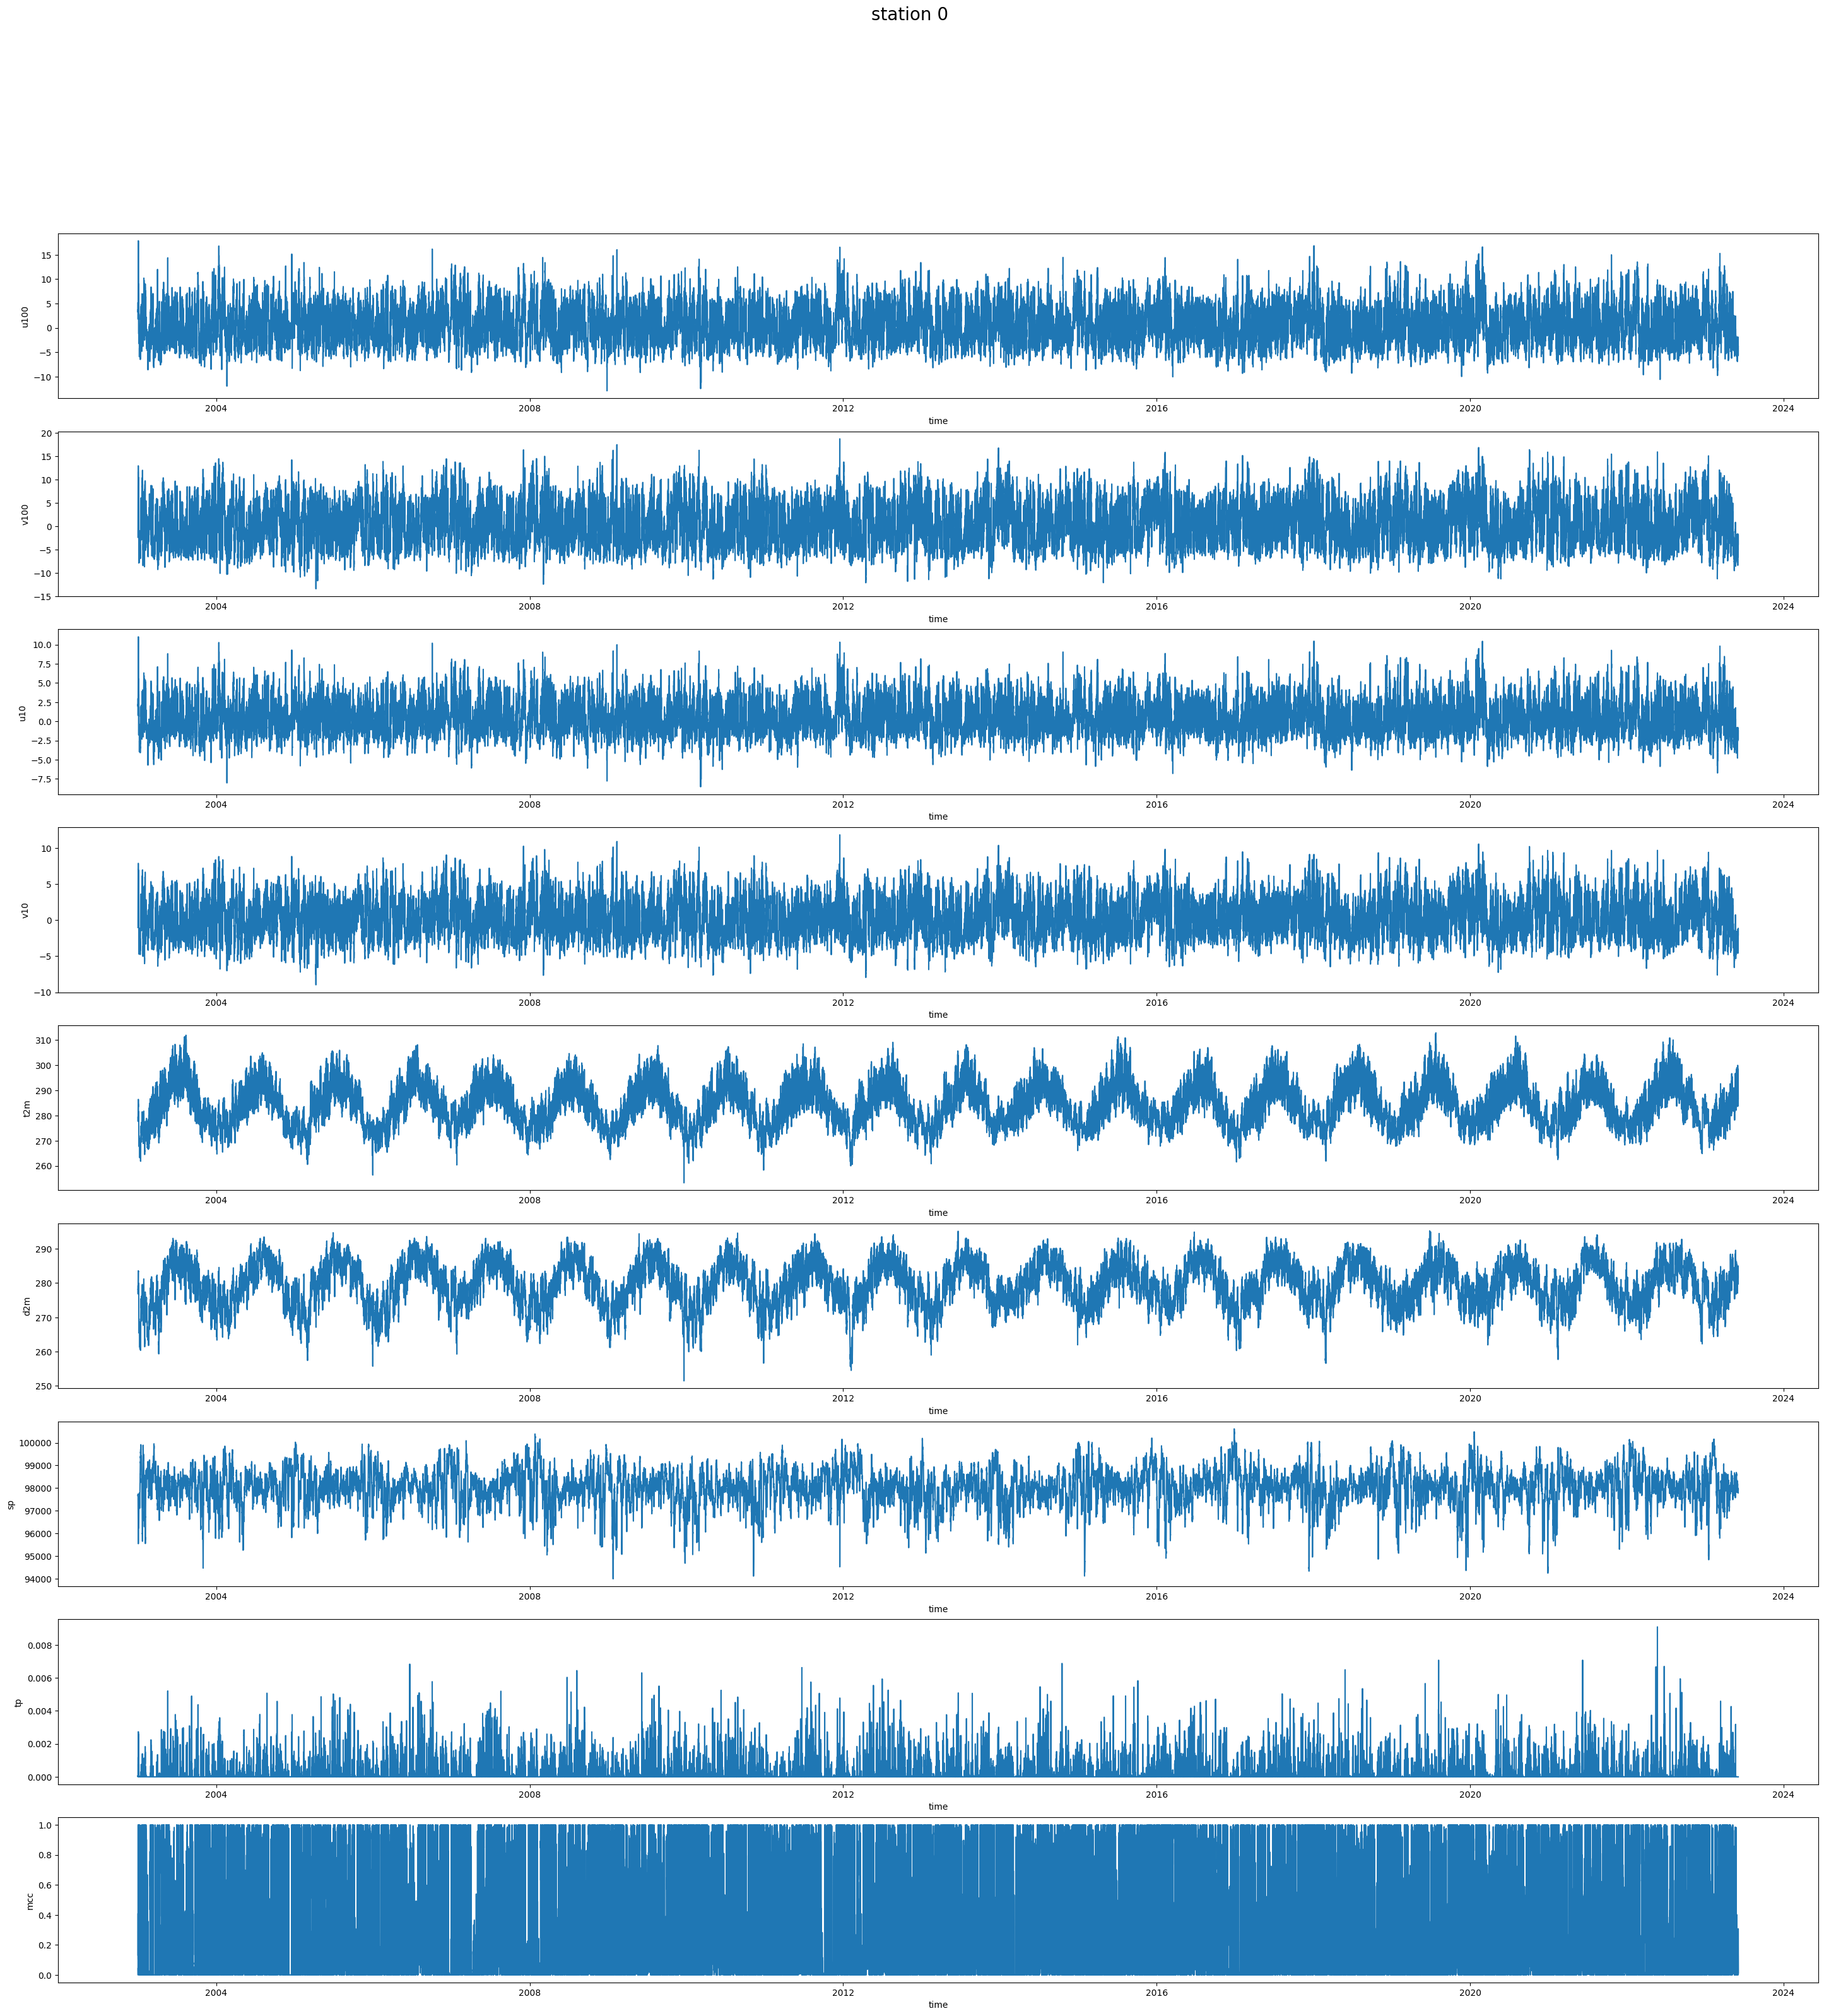

In [31]:
fig, ax = plt.subplots(len(variables),1,figsize=(4*len(variables),4*len(variables)))
fig.suptitle('station 0',fontsize=20)
for i,k in enumerate(variables):
    ax[i].plot(ds.time.values, ds[k][:,0,0].values)
    ax[i].set_ylabel(variables[i])
    ax[i].set_xlabel('time')

We can also visualize the correlation between the timeseries in different routes.

Text(0, 0.5, 'station number')

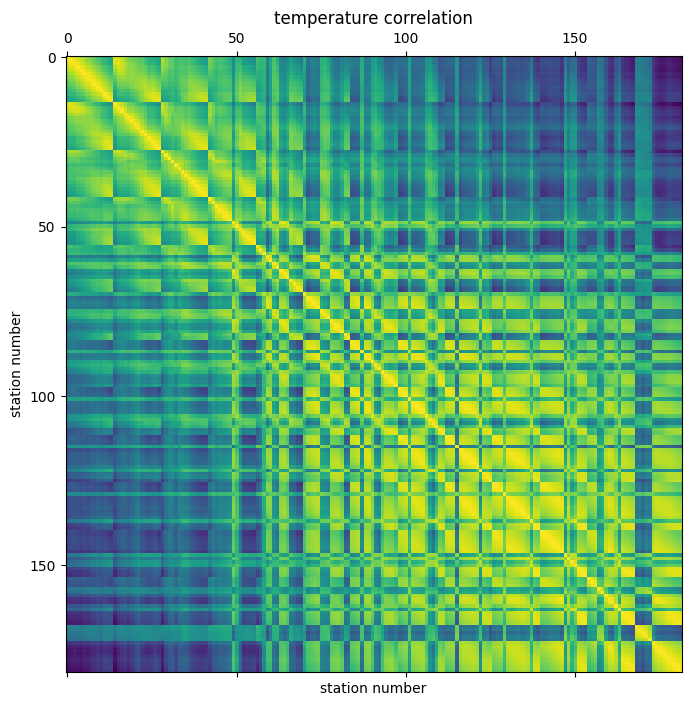

In [32]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(ds.t2m.values.reshape(len(ds.time), -1).T), 0)
plt.title('temperature correlation')
plt.xlabel("station number")
plt.ylabel("station number")

Using this correlation heatmap, we can see that for example the speed in
routes 0,2 and 1,3 are highly correlated.

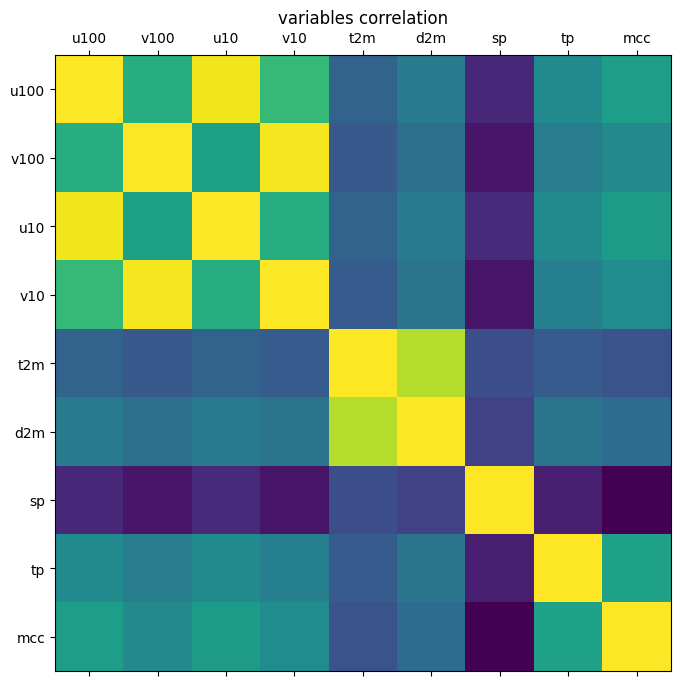

In [33]:
plt.figure(figsize=(8, 8))
mat = np.corrcoef(ds.to_array().values.reshape(len(variables),len(ds.time), -1)[...,0]);
plt.matshow(mat, 0);
plt.title('variables correlation');
plt.xticks(np.arange(len(variables)),variables);
plt.yticks(np.arange(len(variables)),variables);

We can observe important frequencies for the seasonality of the timeseries, observe that most important frequencies are yearly and daily ones:

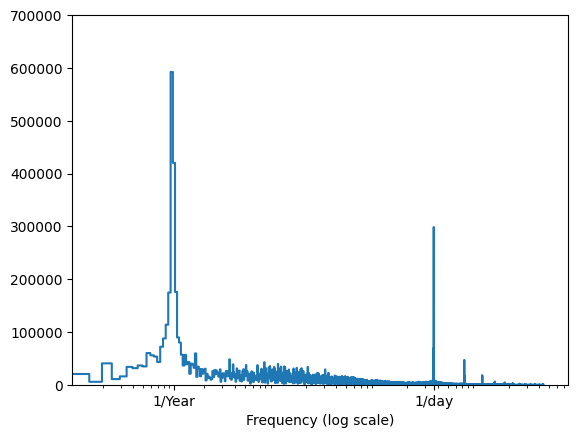

In [36]:
fft = tf.signal.rfft(ds.t2m[:,0,0])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(ds.t2m[:,0,0])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 700000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


Here we can define two custom functions for computing time vectorization and sinusoidal embedding of hours in a day and in a year:

In [34]:
def sinusoidal_embedding(x, period):
    angular_speeds = 2.0 * math.pi / period
    embeddings = tf.stack(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=-1
    )
    return embeddings

def hr2emb(hr, d_period=24, y_period=8783):
    return tf.concat([sinusoidal_embedding(hr, period=d_period), sinusoidal_embedding(hr, period=y_period)], axis=-1)  # we are considering only small interval of years

In [35]:
timestamps = ds.time.values
timehours = np.tile(dt2hr(timestamps)[:,None,None],(1,len(ds.latitude)*len(ds.longitude),1))
MAX_HRS = timehours.max()
MAX_HRS

8783

### Splitting and normalizing data

Next, we split the speed values array into train/validation/test sets,
and normalize the resulting arrays:

In [ ]:
data = np.transpose(ds.to_array().values, (1,2,3,0))
data = np.reshape(data, (data.shape[0],-1,data.shape[-1]))
print(data.shape)

In [ ]:
train_size, val_size, test_size = 0.7, 0.2, 0.1

def preprocess(data_array: np.ndarray, train_size: float, val_size: float, timeembeds: np.array = None):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val, num_test = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
        int(num_time_steps * test_size),
    )
    train_array = data_array[:num_train]
    mean, std = np.nanmean(train_array, axis=(0,1), keepdims=True), np.nanstd(train_array, axis=(0,1), keepdims=True) # (0,1)
    print('mean: ', mean,'\nstd:', std)
    train_array = np.where(np.isfinite(train_array),(train_array - mean) / std, 0)
    val_array = data_array[num_train : (num_train + num_val)]
    val_array = np.where(np.isfinite(val_array),(val_array - mean) / std, 0)
    test_array = data_array[(num_train + num_val):(num_train + num_val + num_test)]
    test_array = np.where(np.isfinite(test_array),(test_array - mean) / std, 0)

    train_array = np.concatenate([train_array, timeembeds[:num_train]], axis=-1)
    val_array = np.concatenate([val_array, timeembeds[num_train : (num_train + num_val)]], axis=-1)
    test_array = np.concatenate([test_array, timeembeds[(num_train + num_val):(num_train + num_val + num_test)]], axis=-1)

    return train_array, val_array, test_array, (mean, std)


train_array, val_array, test_array, (MEAN, STD) = preprocess(data, train_size, val_size, timehours)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

### Creating TensorFlow Datasets

Next, we create the datasets for our forecasting problem. The forecasting problem
can be stated as follows: given a sequence of the values at times `t+1, t+2, ..., t+T`, we want to predict the future values for times `t+T+1, ..., t+T+h`. So for each time `t` the inputs to our
model are `T` vectors each of size `N` and the targets are `h` vectors each of size `N`,
where `N` is the number of weather stations.

We use the Keras built-in function
[`timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).
The function `create_tf_dataset()` below takes as input a `numpy.ndarray` and returns a
`tf.data.Dataset`. In this function `input_sequence_length=T` and `forecast_horizon=h`.

The argument `multi_horizon` needs more explanation. Assume `forecast_horizon=3`.
If `multi_horizon=True` then the model will make a forecast for time steps
`t+T+1, t+T+2, t+T+3`. So the target will have shape `(T,3,n_vars)`. But if
`multi_horizon=False`, the model will make a forecast only for time step `t+T+3` and
so the target will have shape `(T,1,n_vars)`.

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def create_tf_dataset(
    data_array: np.ndarray,
    # time_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        None,
        # time_array[:-forecast_horizon],
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(len(dataset))

    return dataset.prefetch(100).cache()


### Distance Graph

As mentioned before, we assume that the weather stations form a graph.
The next step is to create the graph adjacency matrix from these distances. Following
[Yu et al., 2018](https://arxiv.org/abs/1709.04875) (equation 10) we assume there
is an edge between two nodes in the graph if the distance between the corresponding nodes
is less than a threshold.

In [ ]:

def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    adj = (np.exp(-w2 / sigma2)) #* w_mask
    return 1 * (adj >= epsilon)


The function `compute_adjacency_matrix()` returns a boolean adjacency matrix
where 1 means there is an edge between two nodes. We use the following class
to store the information about the graph.

In [ ]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.05
epsilon = 0.7
adjacency_matrix = compute_adjacency_matrix(distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix > 0)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

In [ ]:
plt.imshow(adjacency_matrix)

## Network architecture

Our model for forecasting over the graph consists of a graph convolution
layer and a LSTM layer.

### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gnn_citations/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight_mess`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages and projecting with `sefl.weight_out`

In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        dropout: typing.Optional[int] = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.activation = layers.Activation(activation)
        self.dropout = tf.keras.layers.Dropout(dropout)


    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1]) 
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight_mess)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(tf.matmul(h, self.weight_out))

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.out_feat),
                                initializer='glorot_normal',
                                trainable=True, name='weights')
        self.weight_mess = self.add_weight(shape=(input_shape[-1], self.out_feat),
                                initializer='glorot_normal',
                                trainable=True, name='weights_mess')
        self.weight_out = self.add_weight(shape=(self.out_feat*2 if self.combination_type == "concat" else  self.out_feat, self.out_feat),
                                initializer='glorot_normal',
                                trainable=True, name='weights_out')

    def call(self, features: tf.Tensor, training: bool = True):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.dropout(self.update(nodes_representation, aggregated_messages), training=training)


### Graph attention layer

Our implementation of the graph attention layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gat_node_classification/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph attention layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations multiplyed by
`self.weight_mess`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages and projecting with `sefl.weight_out`

In [ ]:
class GraphAtt(layers.Layer):
    def __init__(
        self,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        att_activation: typing.Optional[str] = 'leaky_relu',
        dropout: typing.Optional[int] = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.activation = layers.Activation(activation)
        self.att_activation = layers.Activation(att_activation)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def get_attention_scores(self, node_representations: tf.Tensor, neighbour_representations: tf.Tensor):
        concat_representation = tf.concat([node_representations, neighbour_representations], axis=-1)
        att_scores = tf.exp(self.att_activation(tf.squeeze(tf.matmul(concat_representation, self.weight_mess),axis=-1)))
        att_scores_sum = tf.math.unsorted_segment_sum(
            att_scores, 
            self.graph_info.edges[0],
            num_segments=self.graph_info.num_nodes,
            )
        att_scores_sum = tf.repeat(
            att_scores_sum, tf.math.bincount(self.graph_info.edges[0]), axis=0
        )
        att_scores_norm = tf.math.divide_no_nan(att_scores ,att_scores_sum)
        return att_scores_norm


    def compute_aggregated_messages(self, features: tf.Tensor):
        node_representations = tf.gather(features, self.graph_info.edges[0]) 
        neighbour_representations = tf.gather(features, self.graph_info.edges[1]) 
        att_scores_norm = self.get_attention_scores(node_representations, neighbour_representations)
        aggregated_messages = self.aggregate(neighbour_representations * att_scores_norm[...,None])
        return aggregated_messages

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(tf.matmul(h, self.weight_out))

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.out_feat),
                                initializer='glorot_normal',
                                trainable=True, name='weights')
        self.weight_mess = self.add_weight(shape=(input_shape[-1]*2, 1),
                                initializer='glorot_normal',
                                trainable=True, name='weights_mess')
        self.weight_out = self.add_weight(shape=(self.out_feat*2 if self.combination_type == "concat" else  self.out_feat, self.out_feat),
                                initializer='glorot_normal',
                                trainable=True, name='weights_out')

    def call(self, features: tf.Tensor, training: bool = False):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(nodes_representation)
        return self.dropout(self.update(nodes_representation, aggregated_messages), training=training)


### LSTM + GNN

By applying the graph layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `SpatioTemporalAR` layer below, first applies
a graph layer to the inputs and then passes the results through a
`LSTM` layer.

In [ ]:
class SpatioTemporalAR(layers.Layer):
    """An autoregressive layer comprising an LSTM and dense layers."""

    def __init__(
        self,
        in_feat: int,
        lstm_units: int,
        nn_blocks: int, 
        in_seq_len: int,
        out_seq_len: int,
        pos_emb: tf.Tensor,
        gnn_units: int,
        graph_info: typing.Optional[GraphInfo] = None,
        graph_params: typing.Optional[dict] = None,
        gnn_type:  typing.Optional[layers.Layer] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        
        gnn_types = {"conv": GraphConv, "att": GraphAtt}
        # graph conv layer
        if graph_params is None and gnn_type is not None and graph_info is not None:
            graph_params = {
                "aggregation_type": "mean",
                "combination_type": "add",
                "activation": None,
            }

        assert nn_blocks > 1, "Network should be at least 2 layers depth"
        self.lstm_units = lstm_units
        self.nn_blocks = nn_blocks

        self.lstm_cells = [
            layers.LSTMCell(self.lstm_units * (i+1), dropout=0.05) if (i+1)<=(self.nn_blocks//2)+1*(self.nn_blocks%2)
            else layers.LSTMCell(self.lstm_units * (self.nn_blocks-i), dropout=0.05)
            for i in range(0,self.nn_blocks)  
        ]

        self.lstm = [
            tf.keras.layers.RNN(cell, return_sequences=True, return_state=True) for cell in self.lstm_cells
        ]
        
        self.in_feat = in_feat
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len

        self.graph_info = graph_info
        self.gnn_units = gnn_units
        self.gnn_type = gnn_type
        self.graph_params = graph_params

        if self.gnn_type is not None:
            assert self.gnn_type in gnn_types, "gnn_type not exists"
            gnn_builder = gnn_types[self.gnn_type]
            self.gcn = [gnn_builder(self.gnn_units * (i+1), graph_info, **graph_params) if (i+1)<=(self.nn_blocks//2)+1*(self.nn_blocks%2)
                else gnn_builder(self.gnn_units * (self.nn_blocks-i), graph_info, **graph_params)
                for i in range(self.nn_blocks)]
            self.gcn = self.gcn[:-1] # last layer is LSTM output
            self.gcn.append(tf.keras.layers.Identity())
        else:
            self.gcn = [tf.keras.layers.Identity() for _ in range(self.nn_blocks)]

        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(self.lstm_units*2,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.Dense(self.in_feat,kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
        ])

        self.pos_emb = tf.identity(pos_emb) # (num_nodes, feats)

    def do_warmup(self, inputs, training=True):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """
        
        shape = tf.shape(inputs)
        batch_size, in_seq_len, num_nodes = shape[0], shape[1], shape[2]

        inputs = tf.concat([inputs, tf.tile(self.pos_emb[None,None], (batch_size, in_seq_len, 1, 1))],axis=-1) # batch_size, input_seq_len, num_nodes, in_feat

        x = tf.transpose(inputs, [0, 2, 1, 3]) # batch_size, num_nodes, input_seq_len, in_feat

        x = tf.reshape(x,(batch_size * num_nodes, in_seq_len, tf.shape(x)[-1])) # lstm flatten

        states =  []
        for lstm, gcn in zip(self.lstm, self.gcn):
            x, *state = lstm(
                    x, training=training 
                )   # output has shape: (batch_size * num_nodes, in_seq_len, lstm_units)
            states.append(state)
            x = tf.reshape(x,(batch_size, num_nodes, in_seq_len, tf.shape(x)[-1]))
            x = tf.transpose(x, [1, 0, 2, 3]) # num_nodes, batch_size, input_seq_len, in_feat
            x = gcn(x, training=training)
            x = tf.transpose(x, [1, 0, 2, 3]) # batch_size, num_nodes, input_seq_len, in_feat
            x = tf.reshape(x,(batch_size * num_nodes, in_seq_len, tf.shape(x)[-1])) # lstm flatten

        y = self.mlp(x[:,-1], training=training)  # dense_output has shape: (batch_size * num_nodes, in_feat)
        
        prediction = tf.reshape(y, (batch_size, num_nodes, self.in_feat))[:,None] # returns Tensor of shape (batch_size, 1, num_nodes, in_feat)
        return prediction, states

    def do_ar(self, inputs, prev_states=None, training=True):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """
        
        shape = tf.shape(inputs)
        batch_size, in_seq_len, num_nodes = shape[0], shape[1], shape[2]

        inputs = tf.concat([inputs, tf.tile(self.pos_emb[None,None], (batch_size, in_seq_len, 1, 1))],axis=-1) # batch_size, input_seq_len, num_nodes, in_feat

        x = tf.transpose(inputs, [0, 2, 1, 3]) # batch_size, num_nodes, input_seq_len, in_feat

        x = tf.reshape(x,(batch_size * num_nodes, in_seq_len, tf.shape(x)[-1])) # lstm flatten

        states = []
        for cell, gcn, state in zip(self.lstm_cells, self.gcn, prev_states):
            
            x = tf.squeeze(x, 1)
            x, state = cell(
                    x, states=state, training=training
                )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
            states.append(state)
            x = tf.reshape(x,(batch_size, num_nodes, in_seq_len, tf.shape(x)[-1]))
            x = tf.transpose(x, [1, 0, 2, 3]) # num_nodes, batch_size, input_seq_len, in_feat
            x = gcn(x, training=training)
            x = tf.transpose(x, [1, 0, 2, 3]) # batch_size, num_nodes, input_seq_len, in_feat
            x = tf.reshape(x,(batch_size * num_nodes, in_seq_len, tf.shape(x)[-1])) # lstm flatten

        out = self.mlp(x[:,-1], training=training) # dense_output has shape: (batch_size * num_nodes, in_feat)
        prediction = tf.reshape(out, (batch_size, num_nodes, self.in_feat))[:,None] # returns Tensor of shape (batch_size, 1, num_nodes, in_feat)
        return prediction, states

    def call(self, inputs, training=True):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        last_times = tf.identity(inputs[:,-1:,:,-1])
        inputs = tf.concat([inputs[...,:-1],hr2emb(inputs[...,-1])],axis=-1)
        # Initialize the LSTM state.
        prediction, state = self.do_warmup(inputs, training=training)
        # Insert the first prediction.
        predictions.append(prediction)
        # Run the rest of the prediction steps.
        for n in range(1, self.out_seq_len):
            # Use the last prediction as input.
            x = prediction
            last_times += 1
            x = tf.concat([x,hr2emb(last_times)],axis=-1)
            # Execute one lstm step.
            prediction, state = self.do_ar(x, prev_states=state, training=training)
            # Add the prediction to the output.
            predictions.append(prediction)

        predictions = tf.concat(predictions, axis=1)
        return predictions

    def get_config(self):
        config = super().get_config()
        config.update({
            "in_feat": self.in_feat,
            "lstm_units": self.lstm_units,
            "nn_blocks": self.nn_blocks, 
            "in_seq_len": self.in_seq_len,
            "out_seq_len": self.out_seq_len,
            "gnn_units": self.gnn_units,
            "graph_info": self.graph_info.__dict__,
            "graph_params": self.graph_params,
            "gnn_type": self.gnn_type,
        })
        return config

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index: int ,forecast_horizon:int):
    super().__init__()
    self.label_index = label_index
    self.forecast_horizon = forecast_horizon

  def call(self, inputs):
    result = tf.tile(inputs[:, -1:, :, :self.label_index],(1,self.forecast_horizon,1,1))
    return result
  

# baseline = Baseline(label_index=len(variables),forecast_horizon=forecast_horizon)

## Model training

We use the last 24 hours of the timeseries in each station to forecast the value for 8 hours ahead:

In [ ]:
in_feat = len(variables)
nn_blocks = 5
epochs = 80
input_sequence_length = 24
forecast_horizon = 8
multi_horizon = True
lstm_units = 32

graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": "relu",
}

graph_att_params = {
    "aggregation_type": "sum",
    "combination_type": "add",
    "activation": "relu",
    "att_activation": "leaky_relu", # alpha 0.2
}

# create positional embedding
pos_emb = ((coords_km - coords_km.min(axis=0,keepdims=True)) / (coords_km.max(axis=0,keepdims=True) - coords_km.min(axis=0,keepdims=True))).astype(np.float32)

class MaskedMSE(keras.losses.MeanSquaredError):
    def __init__(self, topk_vars, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.topk_vars = topk_vars

    def __call__(self, y_true, y_pred, sample_weight=None):
        return super().__call__(y_true[...,:self.topk_vars], y_pred[...,:self.topk_vars], sample_weight)


class MaskedMAE(keras.losses.MeanAbsoluteError):
    def __init__(self, topk_vars, n_var:int, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.topk_vars = topk_vars
        self.n_var = n_var

    def __call__(self, y_true, y_pred, sample_weight=None):
        return super().__call__(y_true[...,:self.topk_vars], y_pred[...,:self.topk_vars], sample_weight)


In [ ]:
exps = [
    dict(name='lstm', lr=1e-2, batch_size=512, graph=None, graph_info=None, graph_params=None),
    dict(name='conv', lr=4e-3, batch_size=128, graph="conv", graph_info=graph, graph_params=graph_conv_params),
    dict(name='att', lr=1e-3, batch_size=72, graph="att", graph_info=graph, graph_params=graph_att_params),
]

for i,exp in enumerate(exps):

    print(f'Experiment {i}:', exp)

    st_ar = SpatioTemporalAR(
        in_feat = in_feat,
        lstm_units = lstm_units,
        nn_blocks = nn_blocks,
        in_seq_len = input_sequence_length,
        out_seq_len = forecast_horizon,
        pos_emb = pos_emb,
        gnn_units = lstm_units,
        graph_info = exp['graph_info'],
        graph_params = exp['graph_params'],
        gnn_type = exp['graph']
    )

    inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat+1))
    outputs = st_ar(inputs)
    model = keras.models.Model(inputs, outputs)
    model.trainable = True

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=exp['lr']),
        loss=MaskedMSE(topk_vars=len(variables),reduction=tf.keras.losses.Reduction.AUTO),
        metrics=[MaskedMAE(topk_vars=len(variables),n_var=i,name=f'{k}_mae',reduction=tf.keras.losses.Reduction.NONE) for i,k in enumerate(variables)]
    )

    train_dataset, val_dataset = (
        create_tf_dataset(
            data_array, 
            input_sequence_length, 
            forecast_horizon, 
            exp['batch_size'])
        for data_array in [train_array, val_array]
    )

    test_dataset = create_tf_dataset(
        test_array,
        input_sequence_length,
        forecast_horizon,
        batch_size=exp['batch_size'],
        shuffle=False,
        multi_horizon=multi_horizon,
    )


    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=f'model_{exp["name"]}.h5',
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=f'logs_{exp["name"]}',
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        write_steps_per_second=False,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0,
        embeddings_metadata=None,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[modelckpt_callback,tensorboard_callback,keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',mode='min')],
    )

    model.load_weights(f'model_{exp["name"]}.h5')

    import shutil

    model.training=False

    mse, mae = model.evaluate(test_dataset, callbacks=[tensorboard_callback])

    shutil.copyfile(f'model_{exp["name"]}.h5', f'model_{exp["name"]}_{round(mse,4)}_{round(mae,4)}.h5')



## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. Below, we
compute the MAE of the model and compare it to the MAE of naive forecasts.
The naive forecasts are the last value of the speed for each node.

In [ ]:
# model.load_weights('model_lstm.h5')
model.trainable = False
x_test, y = next(test_dataset.as_numpy_iterator())
print(x_test.shape)

print(y.shape)
y_pred = model.predict(x_test)
print(y_pred.shape)

id_station = 0
time = 0
fig, ax = plt.subplots(len(variables),1,figsize=(4*len(variables),4*len(variables)))
fig.suptitle(f'station {id_station}',fontsize=20)
for i in range(len(variables)):
    ax[i].plot(range(x_test.shape[1]), x_test[time, :, id_station, i])
    ax[i].plot(range(x_test.shape[1],x_test.shape[1]+y.shape[1]), y[time, :, id_station, i])
    ax[i].plot(range(x_test.shape[1],x_test.shape[1]+y.shape[1]), y_pred[time, :, id_station, i])
    ax[i].legend(["past","actual", "forecast"])
    ax[i].set_ylabel(variables[i])
    ax[i].set_xlabel('time')

naive_mse, model_mse = (
    np.abs(x_test[:, -1:, :, :len(variables)] - y[:, :, :, :len(variables)]).mean(),
    np.abs(y_pred[:, :, :, :len(variables)] - y[:, :, :, :len(variables)]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

Of course, the goal here is to demonstrate the method,
not to achieve the best performance. To improve the
model's accuracy, all model hyperparameters should be tuned carefully. In addition,
several of the `GraphConv` and `GraphAtt` blocks can be stacked to increase the representation power
of the model.